In [39]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
%%time
df = pd.read_csv('./data/train.csv', nrows=1e6, parse_dates=['click_time'])

CPU times: user 913 ms, sys: 73.6 ms, total: 987 ms
Wall time: 1.02 s


In [33]:
df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [34]:
df.set_index('click_time', inplace=True)

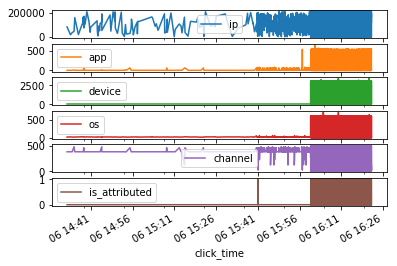

In [53]:
df.plot(subplots=True)
plt.show();